# VGG Training
This notebook trains a vgg19 model on the plant dataset

In [1]:
import time
import os

import numpy as np
import pandas as pd
from plotnine import *
import sklearn.model_selection
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import tqdm

In [2]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed)                                                                    
if torch.backends.cudnn.enabled:                                                                
    torch.backends.cudnn.deterministic = True                                                   
    torch.backends.cudnn.benchmark = False

In [3]:
data_dir = '../data/'

data_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
])

image_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = data_transform)

train_indices, tune_indices = sklearn.model_selection.train_test_split(np.arange(len(image_dataset)), 
                                                                       test_size=.1, random_state=seed)

train_data = torch.utils.data.Subset(image_dataset, train_indices)
tune_data = torch.utils.data.Subset(image_dataset, tune_indices)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
tune_dataloader = torch.utils.data.DataLoader(tune_data)

dataset_size = len(image_dataset)
class_names = image_dataset.classes

device = torch.device("cuda")

#model = torchvision.models.resnet18(num_classes = 12)
model = torchvision.models.vgg19(num_classes = 12)

criterion = nn.CrossEntropyLoss()
criterion = criterion.cpu()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model.to(device)
overall_step = 0
epochs = 250

best_tune_loss = None
tune_losses = []
train_losses = []
tune_accuracies = []

for epoch in tqdm.tqdm_notebook(range(epochs)):  # loop over the dataset multiple times
    train_loss = 0
    tune_loss = 0
    tune_correct = 0
    for data in tqdm.tqdm_notebook(train_dataloader, total=len(train_dataloader)):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    
    for data in tune_dataloader:
        with torch.no_grad():
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            
            tune_loss += criterion(outputs, labels).item()
            tune_correct += accuracy_score(predicted.cpu(), labels.cpu(), normalize=False)
    
    tune_losses.append(tune_loss)
    train_losses.append(train_loss)

    accuracy = tune_correct / len(tune_data)
    tune_accuracies.append(accuracy)
    
    print('Epoch:\t{}\tTrain Loss:\t{}\tTune Loss:\t{}\tTune Acc:\t{}'.format(epoch, train_loss, 
                                                                              tune_loss, accuracy))
            
    # Save model
    if best_tune_loss is None or tune_loss < best_tune_loss:
        best_tune_loss = tune_loss
        torch.save(model.state_dict(), '../results/trained_vgg.pkl')


Epoch:	0	Train Loss:	55155217662086.15	Tune Loss:	4031.493490934372	Tune Acc:	0.12631578947368421



Epoch:	1	Train Loss:	51808.37721371651	Tune Loss:	41541.50407099724	Tune Acc:	0.12842105263157894



Epoch:	2	Train Loss:	579837.2757797241	Tune Loss:	19138.90237236023	Tune Acc:	0.12631578947368421



Epoch:	3	Train Loss:	2654.8664450645447	Tune Loss:	1148.5115747451782	Tune Acc:	0.12631578947368421



Epoch:	4	Train Loss:	962.0292873382568	Tune Loss:	2782.438529610634	Tune Acc:	0.12631578947368421



Epoch:	5	Train Loss:	685.4106566905975	Tune Loss:	1147.5715517997742	Tune Acc:	0.12631578947368421



Epoch:	6	Train Loss:	2045.1479370594025	Tune Loss:	1150.0564346313477	Tune Acc:	0.12631578947368421



Epoch:	7	Train Loss:	5087.896663427353	Tune Loss:	1148.3055572509766	Tune Acc:	0.12631578947368421



Epoch:	8	Train Loss:	1034.888358592987	Tune Loss:	1147.4857201576233	Tune Acc:	0.12631578947368421



Epoch:	9	Train Loss:	747.9104421138763	Tune Loss:	1147.8546102046967	Tune Acc:	0.12631578947368421



Epoch:	10	Train Loss:	176612.1835181713	Tune Loss:	268723.01110076904	Tune Acc:	0.12631578947368421



Epoch:	11	Train Loss:	2374246.0772428513	Tune Loss:	1282262.098123908	Tune Acc:	0.12421052631578948



Epoch:	12	Train Loss:	96868.27202749252	Tune Loss:	1146.9687974452972	Tune Acc:	0.12631578947368421



Epoch:	13	Train Loss:	8890.542036294937	Tune Loss:	1147.7904348373413	Tune Acc:	0.12631578947368421



Epoch:	14	Train Loss:	18101.68340396881	Tune Loss:	71753.66452550888	Tune Acc:	0.12631578947368421



Epoch:	15	Train Loss:	11227.275329589844	Tune Loss:	1148.1078126430511	Tune Acc:	0.11368421052631579



Epoch:	16	Train Loss:	648.0339026451111	Tune Loss:	1148.5331041812897	Tune Acc:	0.12631578947368421



Epoch:	17	Train Loss:	647.8834555149078	Tune Loss:	1146.4726357460022	Tune Acc:	0.12631578947368421



Epoch:	18	Train Loss:	23496.202190876007	Tune Loss:	52002.92457962036	Tune Acc:	0.12421052631578948



Epoch:	19	Train Loss:	2858.1576204299927	Tune Loss:	2453.4721717834473	Tune Acc:	0.12421052631578948



Epoch:	20	Train Loss:	824.0620217323303	Tune Loss:	1147.3782589435577	Tune Acc:	0.11368421052631579



Epoch:	21	Train Loss:	1800.3726890087128	Tune Loss:	1148.8355731964111	Tune Acc:	0.12631578947368421



Epoch:	22	Train Loss:	693.0430903434753	Tune Loss:	1147.9966251850128	Tune Acc:	0.12631578947368421



Epoch:	23	Train Loss:	1102.1911611557007	Tune Loss:	1147.5186026096344	Tune Acc:	0.12631578947368421



Epoch:	24	Train Loss:	647.8955438137054	Tune Loss:	1148.7502143383026	Tune Acc:	0.12631578947368421



Epoch:	25	Train Loss:	648.259747505188	Tune Loss:	1149.0360639095306	Tune Acc:	0.11368421052631579



Epoch:	26	Train Loss:	694.9745178222656	Tune Loss:	1147.9386806488037	Tune Acc:	0.12631578947368421



Epoch:	27	Train Loss:	740.3804395198822	Tune Loss:	1147.3071744441986	Tune Acc:	0.12631578947368421



Epoch:	28	Train Loss:	648.2019543647766	Tune Loss:	1149.4275290966034	Tune Acc:	0.12631578947368421



Epoch:	29	Train Loss:	648.9759202003479	Tune Loss:	1146.0938255786896	Tune Acc:	0.12631578947368421



Epoch:	30	Train Loss:	647.9478352069855	Tune Loss:	1148.1317076683044	Tune Acc:	0.12631578947368421



Epoch:	31	Train Loss:	647.8482205867767	Tune Loss:	1148.55118060112	Tune Acc:	0.12631578947368421



Epoch:	32	Train Loss:	647.8380656242371	Tune Loss:	1147.5488469600677	Tune Acc:	0.11368421052631579



Epoch:	33	Train Loss:	647.9759004116058	Tune Loss:	1147.6689629554749	Tune Acc:	0.12631578947368421



Epoch:	34	Train Loss:	647.9136207103729	Tune Loss:	1149.2496252059937	Tune Acc:	0.12631578947368421



Epoch:	35	Train Loss:	648.8160300254822	Tune Loss:	1147.3284363746643	Tune Acc:	0.12631578947368421



Epoch:	36	Train Loss:	647.9996254444122	Tune Loss:	1148.5562844276428	Tune Acc:	0.12631578947368421



Epoch:	37	Train Loss:	648.1795568466187	Tune Loss:	1149.0448081493378	Tune Acc:	0.11368421052631579



Epoch:	38	Train Loss:	696.4860203266144	Tune Loss:	1147.2605485916138	Tune Acc:	0.12631578947368421



Epoch:	39	Train Loss:	648.1193110942841	Tune Loss:	1148.1787810325623	Tune Acc:	0.11368421052631579



Epoch:	40	Train Loss:	1461.2457044124603	Tune Loss:	1148.8602123260498	Tune Acc:	0.11368421052631579



Epoch:	41	Train Loss:	648.236748456955	Tune Loss:	1146.692904472351	Tune Acc:	0.11368421052631579



Epoch:	42	Train Loss:	648.0272307395935	Tune Loss:	1147.7324662208557	Tune Acc:	0.12631578947368421



Epoch:	43	Train Loss:	667.1349959373474	Tune Loss:	1147.8330116271973	Tune Acc:	0.11368421052631579



Epoch:	44	Train Loss:	648.0366547107697	Tune Loss:	1147.433436870575	Tune Acc:	0.12631578947368421



Epoch:	45	Train Loss:	647.8898599147797	Tune Loss:	1149.6915764808655	Tune Acc:	0.12631578947368421



Epoch:	46	Train Loss:	648.5567548274994	Tune Loss:	1151.1222820281982	Tune Acc:	0.12631578947368421



Epoch:	47	Train Loss:	647.9893362522125	Tune Loss:	1147.2779569625854	Tune Acc:	0.12631578947368421



Epoch:	48	Train Loss:	648.0802409648895	Tune Loss:	1147.563716173172	Tune Acc:	0.12631578947368421



Epoch:	49	Train Loss:	648.0283308029175	Tune Loss:	1146.9561808109283	Tune Acc:	0.11368421052631579



Epoch:	50	Train Loss:	6781.874043464661	Tune Loss:	1148.0654211044312	Tune Acc:	0.11368421052631579



Epoch:	51	Train Loss:	7386.165488243103	Tune Loss:	1147.9410634040833	Tune Acc:	0.11368421052631579



Epoch:	52	Train Loss:	648.0269844532013	Tune Loss:	1148.47984790802	Tune Acc:	0.12631578947368421



Epoch:	53	Train Loss:	756.3994994163513	Tune Loss:	1145.3700852394104	Tune Acc:	0.12631578947368421



Epoch:	54	Train Loss:	704.3910682201385	Tune Loss:	1147.8093302249908	Tune Acc:	0.11368421052631579



Epoch:	55	Train Loss:	674.095263004303	Tune Loss:	1148.0110425949097	Tune Acc:	0.12631578947368421



Epoch:	56	Train Loss:	786.5412859916687	Tune Loss:	1147.8706531524658	Tune Acc:	0.11368421052631579



Epoch:	57	Train Loss:	648.0839645862579	Tune Loss:	1148.490220785141	Tune Acc:	0.12631578947368421



Epoch:	58	Train Loss:	648.2195112705231	Tune Loss:	1146.8264939785004	Tune Acc:	0.12631578947368421



Epoch:	59	Train Loss:	647.995658159256	Tune Loss:	1148.0617344379425	Tune Acc:	0.12631578947368421



Epoch:	60	Train Loss:	647.9831705093384	Tune Loss:	1148.0773251056671	Tune Acc:	0.12631578947368421



Epoch:	61	Train Loss:	648.1586625576019	Tune Loss:	1148.346215724945	Tune Acc:	0.12631578947368421



Epoch:	62	Train Loss:	648.1097431182861	Tune Loss:	2020.047333240509	Tune Acc:	0.12631578947368421



Epoch:	63	Train Loss:	648.278843164444	Tune Loss:	1147.9051885604858	Tune Acc:	0.12631578947368421



Epoch:	64	Train Loss:	647.6898262500763	Tune Loss:	1148.2713260650635	Tune Acc:	0.11368421052631579



Epoch:	65	Train Loss:	648.2349326610565	Tune Loss:	1150.0236146450043	Tune Acc:	0.12631578947368421



Epoch:	66	Train Loss:	648.2036154270172	Tune Loss:	1148.0943398475647	Tune Acc:	0.12631578947368421



Epoch:	67	Train Loss:	648.0940418243408	Tune Loss:	1148.3813123703003	Tune Acc:	0.12631578947368421



Epoch:	68	Train Loss:	648.3433146476746	Tune Loss:	1147.6709399223328	Tune Acc:	0.12631578947368421



Epoch:	69	Train Loss:	648.1301546096802	Tune Loss:	1147.6436274051666	Tune Acc:	0.12631578947368421



Epoch:	70	Train Loss:	894.8283338546753	Tune Loss:	1147.1548981666565	Tune Acc:	0.12631578947368421



Epoch:	71	Train Loss:	692.4275200366974	Tune Loss:	1147.3359847068787	Tune Acc:	0.12631578947368421



Epoch:	72	Train Loss:	648.3261730670929	Tune Loss:	1157.630687713623	Tune Acc:	0.12631578947368421



Epoch:	73	Train Loss:	828.4621775150299	Tune Loss:	3657.3266134262085	Tune Acc:	0.11368421052631579



Epoch:	74	Train Loss:	805.4212152957916	Tune Loss:	1149.2629656791687	Tune Acc:	0.12631578947368421



Epoch:	75	Train Loss:	647.9328396320343	Tune Loss:	1148.2268579006195	Tune Acc:	0.12631578947368421



Epoch:	76	Train Loss:	648.1844737529755	Tune Loss:	1147.9580512046814	Tune Acc:	0.12631578947368421



Epoch:	77	Train Loss:	647.8119833469391	Tune Loss:	1147.748372554779	Tune Acc:	0.12631578947368421



Epoch:	78	Train Loss:	1146.0044734477997	Tune Loss:	1147.4609684944153	Tune Acc:	0.11368421052631579



Epoch:	79	Train Loss:	654.3845055103302	Tune Loss:	1149.0286672115326	Tune Acc:	0.12631578947368421



Epoch:	80	Train Loss:	648.5445401668549	Tune Loss:	1148.217806339264	Tune Acc:	0.12631578947368421



Epoch:	81	Train Loss:	814.4803478717804	Tune Loss:	1146.5829632282257	Tune Acc:	0.12631578947368421



Epoch:	82	Train Loss:	648.3481442928314	Tune Loss:	1153.5530552864075	Tune Acc:	0.12631578947368421



Epoch:	83	Train Loss:	648.012818813324	Tune Loss:	1146.7433931827545	Tune Acc:	0.12631578947368421



Epoch:	84	Train Loss:	647.960152387619	Tune Loss:	1149.4506146907806	Tune Acc:	0.12631578947368421



Epoch:	85	Train Loss:	647.7971043586731	Tune Loss:	1148.4477863311768	Tune Acc:	0.11368421052631579



Epoch:	86	Train Loss:	652.3737163543701	Tune Loss:	1147.0928645133972	Tune Acc:	0.12631578947368421



Epoch:	87	Train Loss:	648.2935283184052	Tune Loss:	1147.5063407421112	Tune Acc:	0.12631578947368421



Epoch:	88	Train Loss:	727.6268503665924	Tune Loss:	1148.7125062942505	Tune Acc:	0.11368421052631579



Epoch:	89	Train Loss:	705.6167893409729	Tune Loss:	1148.7677702903748	Tune Acc:	0.11368421052631579



Epoch:	90	Train Loss:	659.2991154193878	Tune Loss:	1148.5766429901123	Tune Acc:	0.11368421052631579



Epoch:	91	Train Loss:	663.9432394504547	Tune Loss:	1148.1232957839966	Tune Acc:	0.12631578947368421



Epoch:	92	Train Loss:	650.8384213447571	Tune Loss:	1149.35262465477	Tune Acc:	0.12631578947368421



Epoch:	93	Train Loss:	648.0298926830292	Tune Loss:	1149.200845003128	Tune Acc:	0.12631578947368421



Epoch:	94	Train Loss:	653.8558468818665	Tune Loss:	1148.569732427597	Tune Acc:	0.12631578947368421



Epoch:	95	Train Loss:	648.0965807437897	Tune Loss:	1147.1841688156128	Tune Acc:	0.12631578947368421



Epoch:	96	Train Loss:	647.7998442649841	Tune Loss:	1147.016675233841	Tune Acc:	0.12631578947368421



Epoch:	97	Train Loss:	654.6877341270447	Tune Loss:	1147.2928886413574	Tune Acc:	0.12631578947368421



Epoch:	98	Train Loss:	648.0399491786957	Tune Loss:	1148.4010729789734	Tune Acc:	0.12631578947368421



Epoch:	99	Train Loss:	647.9865477085114	Tune Loss:	1148.9507026672363	Tune Acc:	0.12631578947368421



Epoch:	100	Train Loss:	648.2454755306244	Tune Loss:	1147.2411835193634	Tune Acc:	0.12631578947368421



Epoch:	101	Train Loss:	667.7162764072418	Tune Loss:	1148.5438134670258	Tune Acc:	0.12631578947368421



Epoch:	102	Train Loss:	671.9104995727539	Tune Loss:	1147.4061601161957	Tune Acc:	0.12631578947368421



Epoch:	103	Train Loss:	649.3230743408203	Tune Loss:	1149.0017926692963	Tune Acc:	0.12631578947368421



Epoch:	104	Train Loss:	647.7795820236206	Tune Loss:	1149.2511343955994	Tune Acc:	0.12631578947368421



Epoch:	105	Train Loss:	647.9742555618286	Tune Loss:	1147.9668369293213	Tune Acc:	0.12631578947368421



Epoch:	106	Train Loss:	648.2872929573059	Tune Loss:	1147.1404366493225	Tune Acc:	0.12631578947368421



Epoch:	107	Train Loss:	648.1594166755676	Tune Loss:	1148.2872712612152	Tune Acc:	0.11368421052631579



Epoch:	108	Train Loss:	648.3858289718628	Tune Loss:	1146.6693212985992	Tune Acc:	0.12631578947368421



Epoch:	109	Train Loss:	647.8715972900391	Tune Loss:	1148.531188249588	Tune Acc:	0.12631578947368421



Epoch:	110	Train Loss:	648.6200635433197	Tune Loss:	1146.8843710422516	Tune Acc:	0.12631578947368421



Epoch:	111	Train Loss:	647.9911296367645	Tune Loss:	1147.2056908607483	Tune Acc:	0.12631578947368421



Epoch:	112	Train Loss:	647.917685508728	Tune Loss:	1150.0254111289978	Tune Acc:	0.12631578947368421



Epoch:	113	Train Loss:	648.3535785675049	Tune Loss:	1148.480719089508	Tune Acc:	0.12631578947368421



Epoch:	114	Train Loss:	647.9739375114441	Tune Loss:	1146.992086648941	Tune Acc:	0.12631578947368421



Epoch:	115	Train Loss:	647.9426953792572	Tune Loss:	1148.1981670856476	Tune Acc:	0.12631578947368421



Epoch:	116	Train Loss:	667.5981106758118	Tune Loss:	2637.905088663101	Tune Acc:	0.12421052631578948



Epoch:	117	Train Loss:	889.8507244586945	Tune Loss:	1146.6166026592255	Tune Acc:	0.11368421052631579



Epoch:	118	Train Loss:	648.0664887428284	Tune Loss:	1148.7241461277008	Tune Acc:	0.12631578947368421



Epoch:	119	Train Loss:	647.8393309116364	Tune Loss:	1149.3967416286469	Tune Acc:	0.11368421052631579



Epoch:	120	Train Loss:	647.8852951526642	Tune Loss:	1148.9431080818176	Tune Acc:	0.12631578947368421



Epoch:	121	Train Loss:	648.0317275524139	Tune Loss:	1147.383906364441	Tune Acc:	0.11368421052631579



Epoch:	122	Train Loss:	648.254646062851	Tune Loss:	1147.1155214309692	Tune Acc:	0.12631578947368421



Epoch:	123	Train Loss:	648.0247628688812	Tune Loss:	1148.5734107494354	Tune Acc:	0.11368421052631579



Epoch:	124	Train Loss:	648.1544332504272	Tune Loss:	1148.0703389644623	Tune Acc:	0.12631578947368421



Epoch:	125	Train Loss:	647.8686504364014	Tune Loss:	1148.856798171997	Tune Acc:	0.11368421052631579



Epoch:	126	Train Loss:	647.9851982593536	Tune Loss:	1148.9768223762512	Tune Acc:	0.12631578947368421



Epoch:	127	Train Loss:	648.042533159256	Tune Loss:	1148.1031136512756	Tune Acc:	0.12631578947368421



Epoch:	128	Train Loss:	648.1071236133575	Tune Loss:	1148.9015007019043	Tune Acc:	0.12631578947368421



Epoch:	129	Train Loss:	648.0145978927612	Tune Loss:	1148.6005437374115	Tune Acc:	0.11368421052631579



Epoch:	130	Train Loss:	648.1024255752563	Tune Loss:	1148.3023760318756	Tune Acc:	0.12631578947368421



Epoch:	131	Train Loss:	648.1011157035828	Tune Loss:	1148.5767357349396	Tune Acc:	0.12631578947368421



Epoch:	132	Train Loss:	647.9630606174469	Tune Loss:	1148.694910287857	Tune Acc:	0.12631578947368421



Epoch:	133	Train Loss:	647.9678027629852	Tune Loss:	1148.2510125637054	Tune Acc:	0.11368421052631579



Epoch:	134	Train Loss:	671.5782859325409	Tune Loss:	1148.6647334098816	Tune Acc:	0.12631578947368421



Epoch:	135	Train Loss:	681.4550523757935	Tune Loss:	1146.820422410965	Tune Acc:	0.12631578947368421



Epoch:	136	Train Loss:	647.9353051185608	Tune Loss:	1148.6017105579376	Tune Acc:	0.12631578947368421



Epoch:	137	Train Loss:	648.2372419834137	Tune Loss:	1147.9703512191772	Tune Acc:	0.12631578947368421



Epoch:	138	Train Loss:	648.0515265464783	Tune Loss:	1147.4573485851288	Tune Acc:	0.12631578947368421



Epoch:	139	Train Loss:	648.1061029434204	Tune Loss:	1147.584870815277	Tune Acc:	0.12631578947368421



Epoch:	140	Train Loss:	648.4726293087006	Tune Loss:	1147.2771911621094	Tune Acc:	0.12631578947368421



Epoch:	141	Train Loss:	648.0719718933105	Tune Loss:	1148.016602754593	Tune Acc:	0.12631578947368421



Epoch:	142	Train Loss:	648.2791135311127	Tune Loss:	1149.2521147727966	Tune Acc:	0.12631578947368421



Epoch:	143	Train Loss:	648.1047651767731	Tune Loss:	1147.9854636192322	Tune Acc:	0.12631578947368421



Epoch:	144	Train Loss:	648.1737856864929	Tune Loss:	1148.4866530895233	Tune Acc:	0.11368421052631579



Epoch:	145	Train Loss:	648.1923456192017	Tune Loss:	1148.7736752033234	Tune Acc:	0.12631578947368421



Epoch:	146	Train Loss:	648.0081362724304	Tune Loss:	1148.0397953987122	Tune Acc:	0.12631578947368421



Epoch:	147	Train Loss:	647.8119223117828	Tune Loss:	1147.3459832668304	Tune Acc:	0.11368421052631579



Epoch:	148	Train Loss:	648.2349827289581	Tune Loss:	1147.577857017517	Tune Acc:	0.12631578947368421



Epoch:	149	Train Loss:	647.8280229568481	Tune Loss:	1147.7857687473297	Tune Acc:	0.11368421052631579



Epoch:	150	Train Loss:	648.1658396720886	Tune Loss:	1147.9916124343872	Tune Acc:	0.12631578947368421



Epoch:	151	Train Loss:	648.2612707614899	Tune Loss:	1148.2946553230286	Tune Acc:	0.12631578947368421



Epoch:	152	Train Loss:	648.0066895484924	Tune Loss:	1148.4594149589539	Tune Acc:	0.12631578947368421



Epoch:	153	Train Loss:	648.3073000907898	Tune Loss:	1148.736340522766	Tune Acc:	0.12631578947368421



Epoch:	154	Train Loss:	648.0340645313263	Tune Loss:	1147.5305795669556	Tune Acc:	0.12631578947368421



Epoch:	155	Train Loss:	647.8016769886017	Tune Loss:	1147.70636677742	Tune Acc:	0.12631578947368421



Epoch:	156	Train Loss:	647.7801787853241	Tune Loss:	1148.6700491905212	Tune Acc:	0.12631578947368421



Epoch:	157	Train Loss:	648.1286628246307	Tune Loss:	1147.8282551765442	Tune Acc:	0.11368421052631579



Epoch:	158	Train Loss:	647.8804206848145	Tune Loss:	1148.3585753440857	Tune Acc:	0.12631578947368421



Epoch:	159	Train Loss:	929.2276904582977	Tune Loss:	1147.436841249466	Tune Acc:	0.12631578947368421



Epoch:	160	Train Loss:	647.8326671123505	Tune Loss:	1203.812310218811	Tune Acc:	0.12631578947368421



Epoch:	161	Train Loss:	648.0569014549255	Tune Loss:	1148.001395225525	Tune Acc:	0.12631578947368421



Epoch:	162	Train Loss:	648.2520401477814	Tune Loss:	1147.9544332027435	Tune Acc:	0.12631578947368421



Epoch:	163	Train Loss:	648.1921989917755	Tune Loss:	1149.3449387550354	Tune Acc:	0.12631578947368421



Epoch:	164	Train Loss:	647.964907169342	Tune Loss:	1148.7444415092468	Tune Acc:	0.12631578947368421



Epoch:	165	Train Loss:	648.0676684379578	Tune Loss:	1148.183498620987	Tune Acc:	0.12631578947368421



Epoch:	166	Train Loss:	650.8069052696228	Tune Loss:	1148.0566003322601	Tune Acc:	0.12631578947368421



Epoch:	167	Train Loss:	647.8835179805756	Tune Loss:	1147.547076702118	Tune Acc:	0.12631578947368421



Epoch:	168	Train Loss:	648.0785095691681	Tune Loss:	1147.9465777873993	Tune Acc:	0.12631578947368421



Epoch:	169	Train Loss:	648.4255158901215	Tune Loss:	1148.226371049881	Tune Acc:	0.12631578947368421



Epoch:	170	Train Loss:	647.9932992458344	Tune Loss:	1147.308702468872	Tune Acc:	0.12631578947368421



Epoch:	171	Train Loss:	648.1152191162109	Tune Loss:	1148.6189794540405	Tune Acc:	0.12631578947368421



Epoch:	172	Train Loss:	647.7391226291656	Tune Loss:	1148.8618986606598	Tune Acc:	0.12631578947368421



Epoch:	173	Train Loss:	648.3497297763824	Tune Loss:	1147.7947096824646	Tune Acc:	0.11368421052631579



Epoch:	174	Train Loss:	648.2175979614258	Tune Loss:	1148.135535478592	Tune Acc:	0.12631578947368421



Epoch:	175	Train Loss:	647.9023373126984	Tune Loss:	1148.8267254829407	Tune Acc:	0.12631578947368421



Epoch:	176	Train Loss:	647.9483635425568	Tune Loss:	1149.0860707759857	Tune Acc:	0.12631578947368421



Epoch:	177	Train Loss:	648.1399641036987	Tune Loss:	1149.17609000206	Tune Acc:	0.11368421052631579



Epoch:	178	Train Loss:	647.8506162166595	Tune Loss:	1148.6044878959656	Tune Acc:	0.12631578947368421



Epoch:	179	Train Loss:	647.7193727493286	Tune Loss:	1147.9394702911377	Tune Acc:	0.11368421052631579



Epoch:	180	Train Loss:	648.0264575481415	Tune Loss:	1148.263211965561	Tune Acc:	0.11368421052631579



Epoch:	181	Train Loss:	648.2230350971222	Tune Loss:	1146.9368755817413	Tune Acc:	0.12631578947368421



Epoch:	182	Train Loss:	647.8023874759674	Tune Loss:	1147.2443041801453	Tune Acc:	0.12631578947368421



Epoch:	183	Train Loss:	648.4159729480743	Tune Loss:	1147.0113668441772	Tune Acc:	0.12631578947368421



Epoch:	184	Train Loss:	647.9402339458466	Tune Loss:	1148.0223183631897	Tune Acc:	0.12631578947368421



Epoch:	185	Train Loss:	647.9500110149384	Tune Loss:	1148.4684309959412	Tune Acc:	0.12631578947368421



Epoch:	186	Train Loss:	667.8381624221802	Tune Loss:	1148.7016191482544	Tune Acc:	0.12631578947368421



Epoch:	187	Train Loss:	647.8527774810791	Tune Loss:	1148.247510433197	Tune Acc:	0.11368421052631579



Epoch:	188	Train Loss:	665.4324352741241	Tune Loss:	1148.3074803352356	Tune Acc:	0.12631578947368421



Epoch:	189	Train Loss:	648.2757711410522	Tune Loss:	1148.7748367786407	Tune Acc:	0.12631578947368421



Epoch:	190	Train Loss:	648.1104445457458	Tune Loss:	1147.7292695045471	Tune Acc:	0.12631578947368421



Epoch:	191	Train Loss:	648.4319503307343	Tune Loss:	1147.9237835407257	Tune Acc:	0.12631578947368421



Epoch:	192	Train Loss:	678.2631280422211	Tune Loss:	1149.294849872589	Tune Acc:	0.12631578947368421



Epoch:	193	Train Loss:	648.397058725357	Tune Loss:	1148.4132974147797	Tune Acc:	0.12631578947368421



Epoch:	194	Train Loss:	647.9802827835083	Tune Loss:	1149.5877368450165	Tune Acc:	0.11368421052631579



Epoch:	195	Train Loss:	651.2767531871796	Tune Loss:	1148.3934943675995	Tune Acc:	0.12631578947368421



Epoch:	196	Train Loss:	648.0950779914856	Tune Loss:	1148.2779846191406	Tune Acc:	0.12631578947368421



Epoch:	197	Train Loss:	656.5054090023041	Tune Loss:	1146.6563193798065	Tune Acc:	0.11368421052631579



Epoch:	198	Train Loss:	648.4455049037933	Tune Loss:	1147.707410812378	Tune Acc:	0.12631578947368421



Epoch:	199	Train Loss:	648.1197905540466	Tune Loss:	1253.0289878845215	Tune Acc:	0.12631578947368421



Epoch:	200	Train Loss:	648.0871660709381	Tune Loss:	1148.0023543834686	Tune Acc:	0.12631578947368421



Epoch:	201	Train Loss:	647.9034652709961	Tune Loss:	1149.0969777107239	Tune Acc:	0.12631578947368421



Epoch:	202	Train Loss:	648.0387151241302	Tune Loss:	1147.7226133346558	Tune Acc:	0.12631578947368421



Epoch:	203	Train Loss:	648.2355270385742	Tune Loss:	1147.7972304821014	Tune Acc:	0.11368421052631579



Epoch:	204	Train Loss:	648.1675417423248	Tune Loss:	1147.3988499641418	Tune Acc:	0.12631578947368421



Epoch:	205	Train Loss:	647.9114899635315	Tune Loss:	1148.4768526554108	Tune Acc:	0.12631578947368421



Epoch:	206	Train Loss:	647.961418390274	Tune Loss:	1149.1885859966278	Tune Acc:	0.12631578947368421



Epoch:	207	Train Loss:	647.934460401535	Tune Loss:	1148.9628643989563	Tune Acc:	0.12631578947368421



Epoch:	208	Train Loss:	648.2084848880768	Tune Loss:	1149.4886934757233	Tune Acc:	0.12631578947368421



Epoch:	209	Train Loss:	648.1336975097656	Tune Loss:	1147.691320180893	Tune Acc:	0.12631578947368421



Epoch:	210	Train Loss:	648.2721583843231	Tune Loss:	1148.2723393440247	Tune Acc:	0.12631578947368421



Epoch:	211	Train Loss:	648.3229494094849	Tune Loss:	1148.4372026920319	Tune Acc:	0.12631578947368421



Epoch:	212	Train Loss:	647.9812078475952	Tune Loss:	1147.9576404094696	Tune Acc:	0.12631578947368421



Epoch:	213	Train Loss:	647.9803109169006	Tune Loss:	1146.7603125572205	Tune Acc:	0.12631578947368421



Epoch:	214	Train Loss:	648.1369752883911	Tune Loss:	1148.7976956367493	Tune Acc:	0.12631578947368421



Epoch:	215	Train Loss:	647.9288346767426	Tune Loss:	1149.1185874938965	Tune Acc:	0.11368421052631579



Epoch:	216	Train Loss:	647.9414825439453	Tune Loss:	1146.7525594234467	Tune Acc:	0.12631578947368421



Epoch:	217	Train Loss:	648.1757669448853	Tune Loss:	1148.1869497299194	Tune Acc:	0.12631578947368421



Epoch:	218	Train Loss:	647.7181503772736	Tune Loss:	1148.4028458595276	Tune Acc:	0.12631578947368421



Epoch:	219	Train Loss:	666.959743976593	Tune Loss:	1148.033111333847	Tune Acc:	0.12631578947368421



Epoch:	220	Train Loss:	647.7614929676056	Tune Loss:	1147.5827119350433	Tune Acc:	0.12631578947368421



Epoch:	221	Train Loss:	651.0942866802216	Tune Loss:	1149.6043539047241	Tune Acc:	0.12631578947368421



Epoch:	222	Train Loss:	648.014166355133	Tune Loss:	1147.6004707813263	Tune Acc:	0.12631578947368421



Epoch:	223	Train Loss:	648.0992805957794	Tune Loss:	1148.6848058700562	Tune Acc:	0.12631578947368421



Epoch:	224	Train Loss:	647.8886692523956	Tune Loss:	1149.4809095859528	Tune Acc:	0.12631578947368421



Epoch:	225	Train Loss:	648.3518545627594	Tune Loss:	1147.9249813556671	Tune Acc:	0.11368421052631579



Epoch:	226	Train Loss:	648.0213091373444	Tune Loss:	1149.163083076477	Tune Acc:	0.12631578947368421



Epoch:	227	Train Loss:	647.928718328476	Tune Loss:	1147.433827638626	Tune Acc:	0.12631578947368421



Epoch:	228	Train Loss:	648.0170855522156	Tune Loss:	1147.8976287841797	Tune Acc:	0.12631578947368421



Epoch:	229	Train Loss:	648.0709574222565	Tune Loss:	1147.640807390213	Tune Acc:	0.12631578947368421



Epoch:	230	Train Loss:	648.0024342536926	Tune Loss:	1148.2096147537231	Tune Acc:	0.12631578947368421



Epoch:	231	Train Loss:	648.0529935359955	Tune Loss:	1148.0610580444336	Tune Acc:	0.12631578947368421



Epoch:	232	Train Loss:	647.8072049617767	Tune Loss:	1147.6646935939789	Tune Acc:	0.12631578947368421



Epoch:	233	Train Loss:	648.1234760284424	Tune Loss:	1149.491141796112	Tune Acc:	0.12631578947368421



Epoch:	234	Train Loss:	648.0763466358185	Tune Loss:	1148.199074268341	Tune Acc:	0.11368421052631579



Epoch:	235	Train Loss:	648.1039497852325	Tune Loss:	1148.9901378154755	Tune Acc:	0.12631578947368421



Epoch:	236	Train Loss:	648.1188669204712	Tune Loss:	1148.0148165225983	Tune Acc:	0.11368421052631579



Epoch:	237	Train Loss:	647.9242584705353	Tune Loss:	1146.867146730423	Tune Acc:	0.12631578947368421



Epoch:	238	Train Loss:	648.2018921375275	Tune Loss:	1148.5493111610413	Tune Acc:	0.12631578947368421



Epoch:	239	Train Loss:	648.2151181697845	Tune Loss:	1148.117846250534	Tune Acc:	0.12631578947368421



Epoch:	240	Train Loss:	648.1717185974121	Tune Loss:	1147.4105513095856	Tune Acc:	0.12631578947368421



Epoch:	241	Train Loss:	656.9871761798859	Tune Loss:	1148.6725816726685	Tune Acc:	0.12631578947368421



Epoch:	242	Train Loss:	648.2801096439362	Tune Loss:	1147.7349858283997	Tune Acc:	0.12631578947368421



Epoch:	243	Train Loss:	647.6709315776825	Tune Loss:	1148.0567955970764	Tune Acc:	0.11368421052631579



Epoch:	244	Train Loss:	647.9491949081421	Tune Loss:	1148.303109884262	Tune Acc:	0.11368421052631579



Epoch:	245	Train Loss:	647.6524927616119	Tune Loss:	1148.6296498775482	Tune Acc:	0.12631578947368421



Epoch:	246	Train Loss:	648.1254670619965	Tune Loss:	1149.0694086551666	Tune Acc:	0.12631578947368421



Epoch:	247	Train Loss:	647.8123669624329	Tune Loss:	1148.9753391742706	Tune Acc:	0.12631578947368421



Epoch:	248	Train Loss:	648.3739433288574	Tune Loss:	1148.1658236980438	Tune Acc:	0.12631578947368421



Epoch:	249	Train Loss:	647.903228521347	Tune Loss:	1148.3448667526245	Tune Acc:	0.12631578947368421



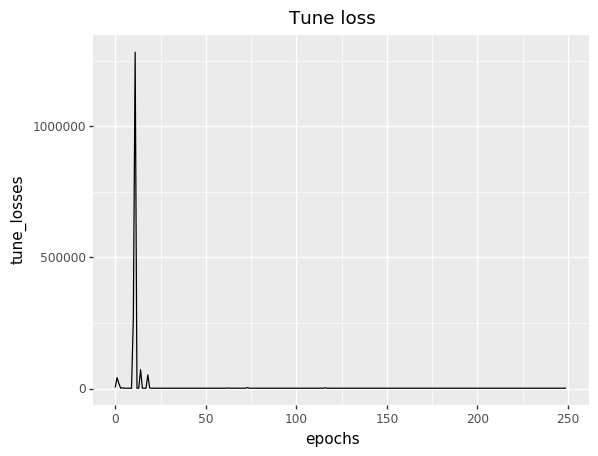

<ggplot: (8735282227157)>

In [4]:
metrics = {'epochs': list(range(epochs)), 'tune_losses': tune_losses, 'train_losses': train_losses,
          'tune_accuracies': tune_accuracies}
metric_df = pd.DataFrame.from_dict(metrics)

ggplot(metric_df, aes(x = 'epochs', y = 'tune_losses')) + geom_line() + ggtitle('Tune loss')

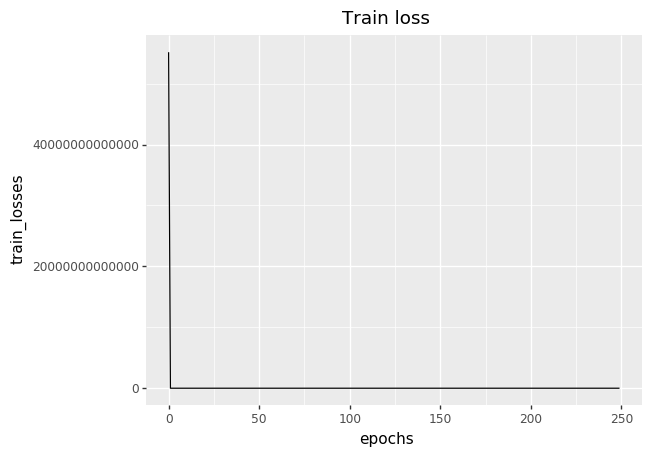

<ggplot: (8735282139945)>

In [5]:
ggplot(metric_df, aes(x = 'epochs', y = 'train_losses')) + geom_line() + ggtitle('Train loss')

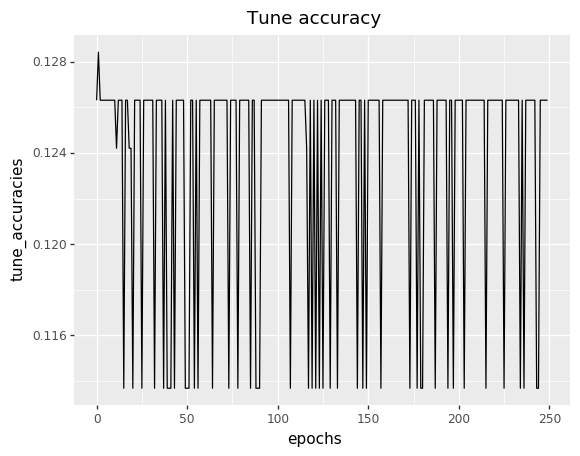

<ggplot: (8735282149717)>

In [6]:
ggplot(metric_df, aes(x = 'epochs', y = 'tune_accuracies')) + geom_line() + ggtitle('Tune accuracy')

In [6]:
from torchvision.datasets import ImageFolder
from torchvision import transforms, models
from torch.utils import data
import torch
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from skimage.io import imread
from numpy.random import poisson, normal, beta, choice
import time
from copy import deepcopy, copy
from PIL import Image
import bagnets.pytorchnet

from dataset import patchnoiser, uniformnoiser, patchswap, tgenerator

In [7]:
seed = 42

np.random.seed(seed)                                                                       
torch.manual_seed(seed) 

img_transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])]
                                   )
dataset = ImageFolder(root='../data/train', transform=img_transform)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [10]:
model_path = "../results/trained_vgg.pkl"

vgg = models.vgg19(num_classes = 12)
vgg.load_state_dict(torch.load(PATH, map_location=device))
vgg.eval() 

index = list(range(794))
columns=['file','species']
df_ = pd.DataFrame(index = index, columns=columns)
df_ = df_.fillna(0)

In [11]:
link = "../data/test"
testset = tgenerator(link)

testset.viewmode()

Evaluate on clean test set.

Kaggle F1 Score: 0.14105

In [12]:
for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(vgg(im),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_vgg.csv", index = False)

0


/Users/jlakkis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/jlakkis/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


100
200
300
400
500
600
700


Evaluate on uniform noise perturbed test set.

Kaggle F1 Score: 0.14105

In [13]:
testset.setmode_uniformnoise(theta=0.6)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(vgg(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_unformnoise_vgg.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on noisy patch perturbed test set.

Kaggle F1 Score: 0.14105

In [14]:
testset.setmode_noiseypatch(theta=0.1,p=30,n=40)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(vgg(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_noiseypatch_vgg.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on patchswap perturbed test set.

Kaggle F1 Score: 0.14105

In [15]:
testset.setmode_patchswap(p=20, n=50)

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(vgg(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_patchswap_vgg.csv", index = False)

0
100
200
300
400
500
600
700


Evaluate on texturized test set.

Kaggle F1 Score: 0.14105

In [16]:
data_dir = "../data/texturized"
testset = tgenerator(data_dir)
testset.viewmode()

for i in range(794):
    im = testset[i]
    im = im.view(1,3,224,224)
    
    ytest = torch.max(vgg(im.float()),1)[1][0].detach()
    
    if(i % 100 ==0):
        print(i)
    
    df_['file'][i] = testset.list_IDs[i]
    df_['species'][i] = dataset.classes[int(ytest)]
    
df_.to_csv(path_or_buf = "../results/predictions_texturized_vgg.csv", index = False)

0
100
200
300
400
500
600
700
